# IIC-2433 Minería de Datos UC

- Versiones de librerías, python 3.8.10

- numpy 1.20.3
- sklearn 1.0.2
- nltk 3.7
- keras 2.9.0
- tensorflow 2.9.1

In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import fetch_20newsgroups

X_train_text, Y_train = fetch_20newsgroups(subset="train", remove=('headers', 'footers', 'quotes'), return_X_y=True)
X_test_text, Y_test  = fetch_20newsgroups(subset="test", remove=('headers', 'footers', 'quotes'), return_X_y=True)


## Actividad en clase

Usando el algoritmo **MLP**, haga lo siguiente:

- Procese el texto del dataset usando el método **tokenize** visto en clases.
- Particione el dataset en **tres** particiones. Para esto, deje en train los primeros 10000 ejemplos de X_train_text y almacene los restantes ejemplos de train en una partición de validación.
- Haga **padding** sobre las tres particiones usando el método visto en clases.
- Cree una red **MLP** con tres capas densas de 256, 128 y 64 neuronas, respectivamente. Agregue una softmax de salida. 
- Entrene usando la particion de train y validación pasando como parámetro del fit() lo siguiente: (validation_data=(X_val_vect, val_y)). Use early_stopping con patience=2
- Evalúe el modelo en la partición de testing usando classification_report.
- Cuanto termine, me avisa para entregarle una **L (logrado)**.
- Recuerde que cada L es una décima más en la nota de la asignatura.
- Pueden trabajar de a dos.

***Tiene hasta el final de la clase.***


# Solución

In [2]:
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, sent_tokenize
from nltk.stem import WordNetLemmatizer

classes = np.unique(Y_train)

# Load stop-words
stop_words = set(stopwords.words('english'))

# Initialize tokenizer
# It's also possible to try with a stemmer or to mix a stemmer and a lemmatizer
tokenizer = RegexpTokenizer('[\'a-zA-Z]+')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

def tokenize(document):
    words = []

    for sentence in sent_tokenize(document):
        tokens = [lemmatizer.lemmatize(t.lower()) for t in tokenizer.tokenize(sentence) if t.lower() not in stop_words and len(t) > 2]
        words += tokens

    text = ' '.join(words)
    return text

In [3]:
train_docs = []
val_docs = []
test_docs = []

for raw_text in X_train_text[:10000]:
    text = tokenize(raw_text)
    train_docs.append(text)
    
for raw_text in X_train_text[10000:]:
    text = tokenize(raw_text)
    val_docs.append(text)
    
for raw_text in X_test_text:
    text = tokenize(raw_text)
    test_docs.append(text)

train_y = []
val_y = []

for label in Y_train[:10000]:
    train_y.append(label)
    
for label in Y_train[10000:]:
    val_y.append(label)
    
train_y = np.asarray(train_y)
val_y = np.asarray(val_y)

In [4]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

max_tokens = 50 ## Hyperparameter, input length

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_docs+val_docs+test_docs)

## Vectorizing data to keep 50 words per sample.
X_train_vect = pad_sequences(tokenizer.texts_to_sequences(train_docs), maxlen=max_tokens, padding="post", truncating="post", value=0.)
X_val_vect = pad_sequences(tokenizer.texts_to_sequences(val_docs), maxlen=max_tokens, padding="post", truncating="post", value=0.)
X_test_vect  = pad_sequences(tokenizer.texts_to_sequences(test_docs), maxlen=max_tokens, padding="post", truncating="post", value=0.)

In [5]:
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Input

inputs = Input(shape=(max_tokens, ))
embeddings_layer = Embedding(input_dim=len(tokenizer.index_word)+1, output_dim=50, input_length=max_tokens, trainable=True)
dense1 = Dense(256, activation="relu")
dense2 = Dense(128, activation="relu")
dense3 = Dense(64, activation="relu")
dense4 = Dense(len(classes), activation="softmax")

x = embeddings_layer(inputs)
x = tf.reduce_mean(x, axis=1) 
x = dense1(x)
x = dense2(x)
x = dense3(x)
outputs = dense4(x)

model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            4753900   
                                                                 
 tf.math.reduce_mean (TFOpLa  (None, 50)               0         
 mbda)                                                           
                                                                 
 dense (Dense)               (None, 256)               13056     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                             

In [6]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [7]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

In [8]:
model.fit(X_train_vect, train_y, batch_size=32, epochs=20, callbacks=[callback], validation_data=(X_val_vect, val_y))

Epoch 1/20
313/313 [==============================] - 10s 29ms/step - loss: 2.6730 - accuracy: 0.1191 - val_loss: 2.2309 - val_accuracy: 0.2443
Epoch 2/20
313/313 [==============================] - 9s 28ms/step - loss: 1.7192 - accuracy: 0.4136 - val_loss: 1.5798 - val_accuracy: 0.4901
Epoch 3/20
313/313 [==============================] - 9s 28ms/step - loss: 0.9047 - accuracy: 0.7116 - val_loss: 1.5510 - val_accuracy: 0.5350
Epoch 4/20
313/313 [==============================] - 9s 28ms/step - loss: 0.4934 - accuracy: 0.8546 - val_loss: 1.6759 - val_accuracy: 0.5753
Epoch 5/20
313/313 [==============================] - 9s 28ms/step - loss: 0.3137 - accuracy: 0.9113 - val_loss: 1.8905 - val_accuracy: 0.5791
Epoch 6/20
313/313 [==============================] - 9s 28ms/step - loss: 0.2324 - accuracy: 0.9408 - val_loss: 2.0894 - val_accuracy: 0.5784
Epoch 7/20
313/313 [==============================] - 9s 28ms/step - loss: 0.1803 - accuracy: 0.9546 - val_loss: 2.3340 - val_accuracy: 0.569

In [9]:
labels = ['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [13]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Y_preds = model.predict(X_test_vect).argmax(axis=-1)

print("Test Accuracy : {}".format(accuracy_score(Y_test, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_test, Y_preds, target_names=labels))

236/236 [==============================] - 1s 2ms/step
Test Accuracy : 0.48234200743494426

Classification Report : 
                          precision    recall  f1-score   support

             alt.atheism       0.24      0.39      0.30       319
           comp.graphics       0.27      0.61      0.38       389
 comp.os.ms-windows.misc       0.53      0.40      0.46       394
comp.sys.ibm.pc.hardware       0.54      0.45      0.49       392
   comp.sys.mac.hardware       0.47      0.52      0.49       385
          comp.windows.x       0.54      0.61      0.57       395
            misc.forsale       0.66      0.52      0.58       390
               rec.autos       0.36      0.57      0.44       396
         rec.motorcycles       0.60      0.42      0.49       398
      rec.sport.baseball       0.73      0.64      0.68       397
        rec.sport.hockey       0.82      0.69      0.75       399
               sci.crypt       0.57      0.57      0.57       396
         sci.electronics

In [14]:
import itertools, matplotlib.pyplot as plt, numpy as np

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


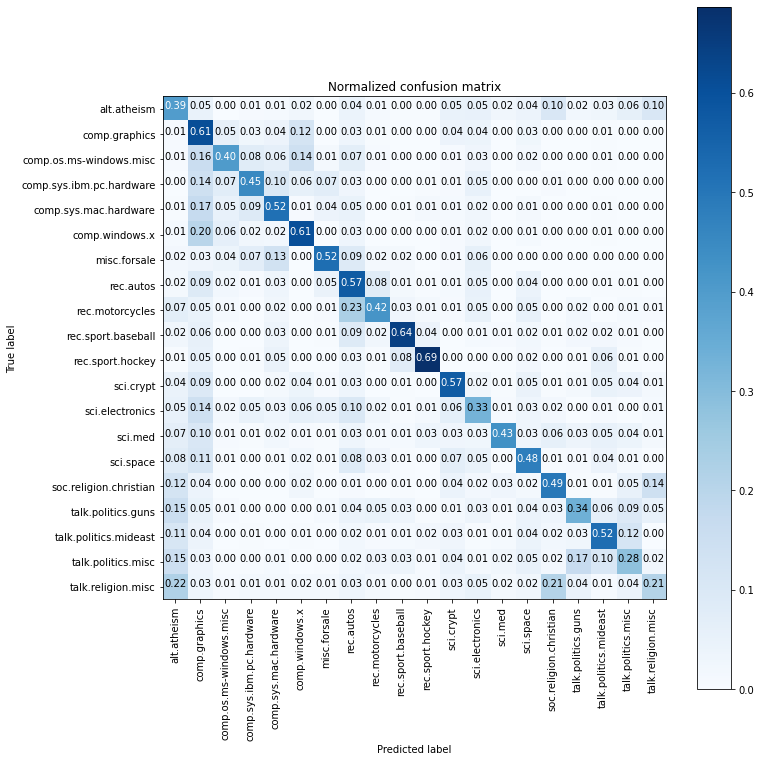

In [15]:
# Compute confusion matrix

cnf_matrix = confusion_matrix(Y_test, Y_preds)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(11, 11))
plot_confusion_matrix(cnf_matrix, classes=labels, normalize=True, title='Normalized confusion matrix')

plt.show()